In [2]:
import pandas as pd
import calc_factors
from calc_factors import dataset, financial_columns, calc_and_simulate_risk_factors
import datetime
import numpy as np

In [4]:
dataset.head()

,dt,close_B_1,close_B_2,close_B_3,close_B_4,close_B_5,close_AFKS,close_AGRO,close_BRENT,close_EUR_RUB__TOD,...,%_7y,%_10y,%_15y,%_20y,%_30y,discounted_coupon_1,discounted_coupon_2,discounted_coupon_3,discounted_coupon_4,discounted_coupon_5
0,2020-01-09,1030.50,1183.29,1091.50,1052.92,994.80,15.075,644.4,66.16,68.0025,...,6.21,6.42,6.61,6.71,6.82,276.518080,338.933068,270.396886,275.185719,231.223384
1,2020-01-10,1037.74,1196.94,1098.98,1061.99,997.99,15.047,640.8,65.86,67.9775,...,6.07,6.26,6.48,6.61,6.75,276.519495,338.934873,270.398318,275.187282,231.224676
2,2020-01-13,1039.70,1199.99,1100.72,1062.03,999.50,15.140,642.6,64.91,67.9400,...,6.00,6.18,6.39,6.52,6.66,276.520542,338.936196,270.399352,275.188412,231.225613
3,2020-01-14,1035.00,1198.00,1098.00,1062.94,999.47,15.625,645.2,65.07,68.3350,...,6.06,6.26,6.47,6.60,6.73,276.520113,338.935652,270.398935,275.187933,231.225212
4,2020-01-15,1032.40,1193.65,1095.75,1058.59,997.49,15.600,644.0,64.84,68.4875,...,6.11,6.30,6.50,6.63,6.76,276.519806,338.935262,270.398636,275.187594,231.224926


In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
from sklearn.decomposition import FastICA
from statsmodels.tsa.stattools import adfuller
import arch
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
dataset = pd.read_excel('dataset_coupons.xlsx')

financial_columns = ['close_B_1', 'close_B_2', 'close_B_3', 'close_B_4', 'close_B_5',
                     'close_AFKS', 'close_AGRO', 'close_BRENT', 'close_EUR_RUB__TOD',
                     'close_GAZP', 'close_IMOEX', 'close_LKOH', 'close_NLMK', 'close_NVTK',
                     'close_PLZL', 'close_ROSN', 'close_RTKM', 'close_RTSI', 'close_SBER',
                     'close_USD000000TOD', '%_0,25y', '%_0,5y', '%_0,75y', '%_1y', '%_2y',
                     '%_3y', '%_5y', '%_7y', '%_10y', '%_15y', '%_20y', '%_30y']

def get_risk_factors(dt_end=datetime.date(2023, 12, 3), dataset=dataset, financial_columns=financial_columns):
    dt_end_datetime = pd.to_datetime(dt_end)
    dataset = dataset[dataset['dt'] < dt_end_datetime].reset_index(drop=True)
    df_financial = dataset[financial_columns]

    ica = FastICA(n_components=10, algorithm='parallel', whiten='unit-variance', fun='logcosh', max_iter=300)
    ica_components = ica.fit_transform(df_financial)
    df_ica = pd.DataFrame(data=ica_components)
    df_ica.columns = [f'risk_factor_{i}' for i in range(len(df_ica.columns))]
    df_ica['dt'] = dataset['dt']
    df_ica = df_ica[['dt'] + [f'risk_factor_{i}' for i in range(len(df_ica.columns) - 1)]]
    dataset = dataset.merge(df_ica, how='left', on='dt')
    return dataset

def garch_simulation(df, risk_factor_col, steps_forward, num_samples):
    model = arch.arch_model(df[risk_factor_col], mean='AR', vol='Garch', p=10, o=0, q=10)
    res = model.fit(disp='off')
    sim_data = res.forecast(horizon=steps_forward, method='simulation')
    means = sim_data.mean.iloc[0].values
    variances = sim_data.variance.iloc[0].values
    simulated_data = np.zeros((num_samples, steps_forward))
    for i in range(steps_forward):
        std_dev = np.sqrt(variances[i])
        simulated_data[:, i] = np.random.normal(means[i], std_dev, num_samples)
    return simulated_data

def calc_and_simulate_risk_factors(dt_end=datetime.date(2023, 12, 3), steps_forward=1, num_samples=1000, dataset=dataset, financial_columns=financial_columns):
    df_risks = get_risk_factors(dt_end=dt_end, dataset=dataset, financial_columns=financial_columns)
    df = df_risks[[f'risk_factor_{i}' for i in range(10)]].copy()
    df.index = df_risks['dt']
    dict_of_risk_simulations = {}
    for risk_factor_col in df.columns:
        dict_of_risk_simulations[risk_factor_col] = garch_simulation(df, risk_factor_col, steps_forward=steps_forward, num_samples=num_samples)
    return df_risks, dict_of_risk_simulations

df_risks, dict_of_risk_simulations = calc_and_simulate_risk_factors(dt_end=datetime.date(2023, 12, 20), steps_forward=1, num_samples=1000)

In [22]:
def calculate_portfolio_values(df_risks, risk_simulations, initial_prices, portfolio_weights):
    num_samples = risk_simulations[next(iter(risk_simulations))].shape[0]
    portfolio_values = np.zeros(num_samples)
    
    for i in range(num_samples):
        sample_value = 0
        for col in initial_prices.keys():
            new_price = initial_prices[col]
            for j in range(10):
                risk_factor_col = f'risk_factor_{j}'
                new_price *= np.exp(risk_simulations[risk_factor_col][i, -1])
            sample_value += portfolio_weights[col] * new_price
        portfolio_values[i] = sample_value
    
    return portfolio_values

def calculate_var_es(portfolio_values, var_confidence=0.99, es_confidence=0.975):
    var_value = np.percentile(portfolio_values, (1 - var_confidence) * 100)
    es_value = portfolio_values[portfolio_values <= var_value].mean()
    return var_value, es_value

In [23]:
# Определение начальных условий
dt_end = datetime.date(2023, 12, 2)
steps_forward_1 = 1
steps_forward_10 = 10
num_samples = 1000
initial_prices = dataset[dataset['dt'] == pd.to_datetime(dt_end) - pd.Timedelta(days=1)].iloc[0][financial_columns].to_dict()

In [21]:
# Пример портфельных весов 
portfolio_weights = {col: 1/len(financial_columns) for col in financial_columns}  # Равные веса

In [26]:
# Симуляции и расчет для горизонта 1 день
df_risks, risk_simulations = calc_and_simulate_risk_factors(dt_end=dt_end, steps_forward=steps_forward_1, num_samples=num_samples, dataset=dataset, financial_columns=financial_columns)
portfolio_values_1 = calculate_portfolio_values(df_risks, risk_simulations, initial_prices, portfolio_weights)
var_1, es_1 = calculate_var_es(portfolio_values_1)

print(f"1-дневный VaR (99%): {var_1}")
print(f"1-дневный ES (97.5%): {es_1}")

1-дневный VaR (99%): 0.008318592625085327
1-дневный ES (97.5%): 0.0027390245139537212


In [27]:
# Симуляции и расчет для горизонта 10 дней
df_risks, risk_simulations = calc_and_simulate_risk_factors(dt_end=dt_end, steps_forward=steps_forward_10, num_samples=num_samples, dataset=dataset, financial_columns=financial_columns)
portfolio_values_10 = calculate_portfolio_values(df_risks, risk_simulations, initial_prices, portfolio_weights)
var_10, es_10 = calculate_var_es(portfolio_values_10)

print(f"10-дневный VaR (99%): {var_10}")
print(f"10-дневный ES (97.5%): {es_10}")

10-дневный VaR (99%): 0.12848655564848158
10-дневный ES (97.5%): 0.06593167187971499


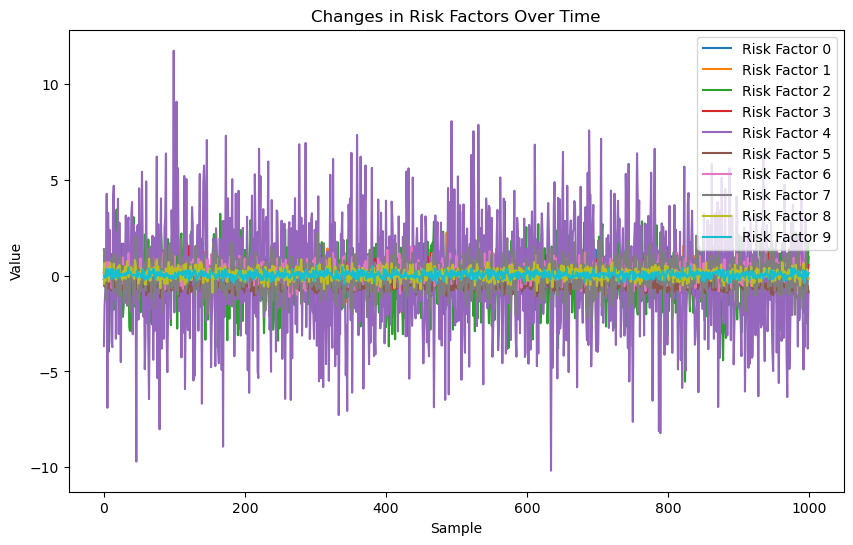

In [30]:
import matplotlib.pyplot as plt
# Визуализация изменений в стоимости портфеля за каждый день симуляции
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(np.arange(num_samples), dict_of_risk_simulations[f'risk_factor_{i}'][:, -1], label=f'Risk Factor {i}')
plt.title('Changes in Risk Factors Over Time')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

### Результаты пункта 5 ###
* Построена выборка из распределения риск-факторов на горизонте оценки риска - это реализовано в функции `calc_and_simulate_risk_factors`.
* По выборке значений риск-факторов построена выборка стоимостей портфеля - это реализовано в функции `calculate_portfolio_values`.
* Ребалансировка активов, чтобы сохранить пропорции, указанные в условии, осуществляется ежедневно через расчет новых цен на основе симуляций.